# LDA 모델 하이퍼파라미터 결정(토픽 개수)
## 1. NTIS 데이터를 대상으로 하이퍼파라미터(특히 토픽개수)를 변경하며 가장 성능이 좋다고 보이는 파라미터를 설정(Coherence, perplexity score 활용)

In [43]:
#https://bab2min.github.io/tomotopy/v0.12.3/kr/#tomotopy.LDAModel
# Package Load
import pickle
import pyLDAvis
import math
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models.coherencemodel import CoherenceModel
import tomotopy as tp
import tomotopy.coherence as tpc
from gensim.corpora import Dictionary
from datetime import datetime
from tqdm import tqdm
from datetime import datetime
from timeit import default_timer
import plotly.express as px
import plotly.offline
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [44]:
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

### (1) 데이터 불러오기
#### ※ 코퍼스 파일 로드

In [42]:
data_ver=input("사용할 데이터 폴더명을 입력하세요(Default: 엔터키): ")
if data_ver=='':
    DATA_DIR = './data/LDA/Default/'
else:
    DATA_DIR = './data/LDA/'+data_ver+'/'
    
lda_txt=input("사용할 데이터 명을 입력하세요(Default: 엔터키): ")
#LDA_PRED_NTIS_2021_20230104

사용할 데이터 폴더명을 입력하세요(Default: 엔터키): NKIS
사용할 데이터 명을 입력하세요(Default: 엔터키): LDA_PRED_NKIS


In [4]:
# input : data/LDA 폴더에 txt 형태 코퍼스 파일, 없으면 오류 발생

corpus=[]
for n, line in tqdm(enumerate(open(DATA_DIR+lda_txt+".txt", encoding='CP949'))):
    doc=line.strip().split()
    corpus.append(doc)
print("코퍼스 파일 로드가 완료되었습니다.")

76684it [00:02, 26435.77it/s]

코퍼스 파일 로드가 완료되었습니다.


#### ※ temp에 분석에 활용하지 사용하지 않을 단어를 지정할 수 있음(기본 단순 알파벳 및 ㆍ 제거)

In [5]:
from string import ascii_lowercase
from string import ascii_uppercase
alphabet_list = list(ascii_lowercase) + list(ascii_uppercase) + list("ㆍ")
# + list(topic2["0"]) 
#print(len(topic2["0"]))
# 52부터 topic2 51까지 알파벳 대소문자  
len(alphabet_list)

53

In [6]:
unusing_dic = pd.DataFrame()
unusing_dic["term"] = alphabet_list

In [7]:
temp_f =[]
remove_set =unusing_dic["term"].tolist()

for temp_1 in tqdm(corpus) :
    temp_t = [temp_2 for temp_2 in temp_1 if temp_2 not in remove_set]
    temp_f.append(temp_t)
    
corpus = temp_f

100%|██████████████████████████████████████████████████████████████████████████| 76684/76684 [00:13<00:00, 5880.19it/s]


In [8]:
##단어 없는 것 제거(stopword)
temp = []
for cnt in range(len(corpus)):
    if len(corpus[cnt])  != 0 :
        temp.append(corpus[cnt])
        
corpus = temp

In [9]:
## 불용어 제거 후 저장
# temp = pd.DataFrame(index=range(len(corpus)),columns=["corpus"])

# for i in tqdm(range(len(corpus))):
#     temp.iloc[i][0] = ' '.join(map(str, corpus[i]))

# f =open('./data/LDA/'+data_ver+'/'+"LDA_DEL_2.txt",'w')

# for i in tqdm(range(len(temp))):
#     f.writelines(temp.iloc[i]+'\n')
# f.close()

### (2) LDA 모델 최적화
#### ※ LDA 모델에서 토픽 수를 10, 20, 30 ... 으로 5단위씩 증가시키면서 아래에서 입력된 최대 토픽 수까지 모델을 훈련시켜 최적 토픽수를 찾음
#### ※ 정해진 토픽수는 없으며, 분석가의 판단에 따라 결정하는 것임

In [18]:
upper_topic_num = int(input("LDA 모델 최적 토픽 수를 검증하기 위한 최대 토픽 수를 입력하세요. (※ 10이상의 자연수, 권장값 = 250개)"))
iteration = int(input("학습 Iteration 수를 입력하세요. (※ 100이상의 자연수, 권장값 = 1000회)"))

print('\n 최대 토픽 갯수 %s개로 %d회씩 학습을 진행합니다.'%(upper_topic_num,iteration))

LDA 모델 최적 토픽 수를 검증하기 위한 최대 토픽 수를 입력하세요. (※ 10이상의 자연수, 권장값 = 250개)150
학습 Iteration 수를 입력하세요. (※ 100이상의 자연수, 권장값 = 1000회)1000

 최대 토픽 갯수 150개로 1000회씩 학습을 진행합니다.


In [19]:
score_u_list=[]
score_c_list=[]
perplexity_list=[]
for opt_tp in tqdm(range(5, upper_topic_num+5, 5)): 
    model=tp.LDAModel(k=opt_tp, min_cf=1001, rm_top=64 ,tw=tp.TermWeight.PMI, seed=42)
    for cnt in range(len(corpus)):
        model.add_doc(corpus[cnt])
    model.train(iter=iteration, workers=0)
    perplexity_list.append(math.log10(model.perplexity))
    coherence_u=tpc.Coherence(model, coherence='u_mass')
    coherence_c=tpc.Coherence(model, coherence='c_v')
    score_u=coherence_u.get_score()
    score_u_list.append(score_u)
    score_c=coherence_c.get_score()
    score_c_list.append(score_c)

100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [4:23:05<00:00, 526.18s/it]


### 2-(1) Coherence graph : 토픽들이 얼마나 일관성 있는지에 대한 판단 지표
#### ※ 수치가 높을수록 성능이 좋다고 판단

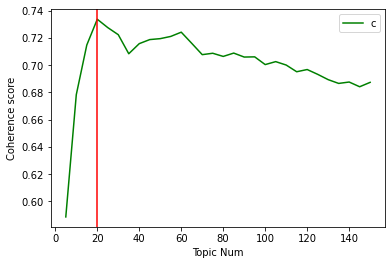

In [39]:
x=range(5, upper_topic_num+5, 5)
plt.plot(x, score_c_list, color='green') 
plt.xlabel("Topic Num") 
plt.ylabel("Coherence score") 
plt.legend(("coherence_values"), loc='best')
plt.axvline(x=20,color='r')
plt.savefig('C:/Users/KISDI/LDA/html/LDA/NTIS/Cor_score_u_'+str(max_index*5)+'.png',facecolor='#eeeeee')
plt.show()

In [21]:
print(max(score_c_list))
max_index = score_c_list.index(max(score_c_list)) +1 
max_index

0.7336540468037128


4

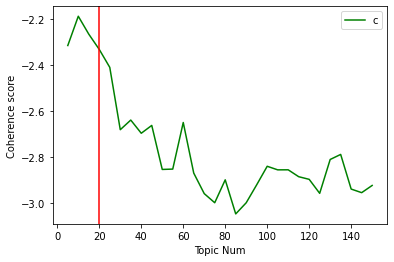

In [22]:
x=range(5, upper_topic_num+5, 5)
plt.plot(x, score_u_list, color='green') 
plt.xlabel("Topic Num") 
plt.ylabel("Coherence score") 
plt.legend(("coherence_values"), loc='best')
plt.axvline(x=20,color='r')
plt.show()

#### (2)-2 Perplexity 그래프 : 확률 모델이 얼마나 잘 예측하는지에 대한 판단 지표
#### 수치가 낮을수록 잘 예측한다고 해석 할 수 있지만, 실제로 연구자가 보고 해석하기는 어려울 수 있음

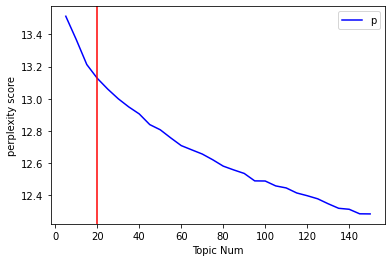

In [41]:
x=range(5, upper_topic_num+5, 5)
plt.plot(x, perplexity_list, color='blue') 
plt.xlabel("Topic Num") 
plt.ylabel("perplexity score") 
plt.legend(("perplexity_values"), loc='best') 
plt.axvline(x=20,color='r')
plt.savefig('C:/Users/KISDI/LDA/html/LDA/NTIS/Per_score'+str(max_index*5)+'.png',facecolor='#eeeeee')
plt.show()

### (3) 최종 토픽개수 결정
#### ※ 앞서 가장 높았던 토픽개수를 기준으로 가까운 토픽개수를 1단위로 관찰

In [12]:
score_u_list_2=[]
score_c_list_2=[]
perplexity_list_2=[]
for opt_tp in tqdm(range(max_index*5-5, max_index*5+5, 1)): 
    model=tp.LDAModel(k=opt_tp, min_cf=1001, rm_top=64 ,tw=tp.TermWeight.PMI, seed=42)
    for cnt in range(len(corpus)):
        model.add_doc(corpus[cnt])
    model.train(iter=iteration, workers=0)
    perplexity_list_2.append(math.log10(model.perplexity))
    coherence_u_2=tpc.Coherence(model, coherence='u_mass')
    coherence_c_2=tpc.Coherence(model, coherence='c_v')
    score_u_2=coherence_u_2.get_score()
    score_u_list_2.append(score_u_2)
    score_c_2=coherence_c_2.get_score()
    score_c_list_2.append(score_c_2)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [23:37<00:00, 141.71s/it]


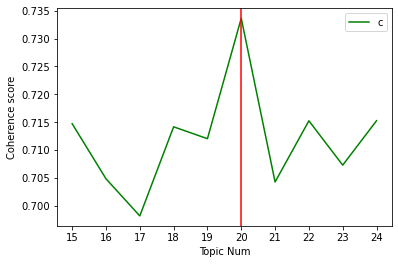

In [40]:
x=range(max_index*5-5, max_index*5+5, 1)
plt.plot(x, score_c_list_2, color='green') 
plt.xlabel("Topic Num") 
plt.ylabel("Coherence score") 
plt.legend(("coherence_values"), loc='best') 
plt.axvline(x=20,color='r')
plt.xticks(np.arange(max_index*5-5, max_index*5+5))
plt.savefig('C:/Users/KISDI/LDA/html/LDA/NTIS/Cor_score'+str(max_index*5)+'_final.png',facecolor='#eeeeee')
plt.show()

In [14]:
print(score_c_list[0:20].index(max(score_c_list[0:20])))

NameError: name 'score_c_list' is not defined

In [ ]:
x=range(10, 30, 1)
plt.plot(x, score_u_list[0:20], color='green') 
plt.xlabel("Topic Num") 
plt.ylabel("Coherence score") 
plt.legend(("coherence_values"), loc='best') 
plt.show()

In [ ]:
x=range(10, 30, 1)
plt.plot(x, perplexity_list[0:20], color='blue') 
plt.xlabel("Topic Num") 
plt.ylabel("perplexity score") 
plt.legend(("perplexity_values"), loc='best')
plt.axvline(x=23,color='r')
plt.xticks(np.arange(10,31))
plt.show()